# Diagrams

## Imports

In [ ]:
# |default_exp diagrams_old

In [ ]:
# | hide
%load_ext autoreload
%autoreload 2

In [ ]:
# | hide
# import jupyter_black

# jupyter_black.load()
from stringdale.core import get_git_root, load_env, checkLogs
import pytest

In [ ]:
load_env()

True

In [ ]:
# FUTURE reference syntax of string diagrams https://arxiv.org/pdf/2305.08768.pdf
# FUTURE in future, add automatic async conversion to functions running in parallel using https://stackoverflow.com/a/70880583
# FUTURE descrive that we have flow diagrams and decision diagrams


In [ ]:
# | export
import os
import sys
import enum
from pathlib import Path
from copy import deepcopy
import itertools
import functools
from enum import Enum
from parse import parse
from typing import Any
from copy import deepcopy,copy


from collections import defaultdict,OrderedDict
from contextlib import ExitStack
from singleton_decorator import singleton

from pprint import pprint
from pydantic import BaseModel
from pydantic_core import SchemaValidator

from typing import Optional,Union,List,Dict,Any,Literal,Callable

import networkx as nx
from networkx.readwrite import json_graph
from fastcore.basics import patch
from tqdm.auto import tqdm
import logging


In [ ]:
#| export
logger = logging.getLogger(__name__)

In [ ]:
#| export
import asyncio
# ! pip install nest_asyncio
import nest_asyncio
nest_asyncio.apply()

In [ ]:
#| export
from IPython.display import display,Image,Markdown


In [ ]:
# | export
from pydantic import BaseModel, ConfigDict
from stringdale.core import jinja_render,checkLogs,maybe_await,_duplicates,wrap_exception,NamedLambda
from stringdale.viz import draw_nx,draw_graphviz,display_in_ipython
from stringdale.mappings import (
    parse_edge_descriptor,
    multi_map,
    assert_keys_contiguous,
    access_object,
    map_object,
    object_to_args_kwargs,
)

import inspect
from textwrap import dedent
from parse import parse
import re
import itertools as it
import types
import uuid
import time
import json

## Diagram State

In [ ]:
#| export
from pydantic import BaseModel,ConfigDict,computed_field
from typing import Annotated

In [ ]:
#| export
class BaseModelExtra(BaseModel):
    model_config = ConfigDict(extra='allow')


In [ ]:
#| export
def _is_attr_method(obj,attr):
    if not hasattr(obj,attr):
        return False
    attr_value = getattr(obj,attr)
    return inspect.ismethod(attr_value)

def get_attr_metadata(obj,attr):
    type_fields = obj.model_fields
    if not attr in type_fields:
        return False
    field_info = type_fields[attr]
    if not hasattr(field_info,'metadata'):
        return False
    if len(field_info.metadata) == 0:
        return False
    return field_info.metadata[0]

@wrap_exception("When getting state key {{key}} from state {{state}}:")
def get_state_key(state,key):
    is_key_method = _is_attr_method(state,key)
    if is_key_method:
        return getattr(state,key)()
    else:
        return getattr(state,key)

@wrap_exception("When setting state key {{key}} to {{value}} in state {{state}}:")
def set_state_key(state,key,value):
    is_key_method = _is_attr_method(state,key)
    attr_metadata_func = get_attr_metadata(state,key)
    if is_key_method:
        getattr(state,key)(value)
    elif attr_metadata_func:
        key_state = get_state_key(state,key)
        attr_metadata_func(key_state,value)
    else:
        setattr(state,key,value)


In [ ]:
class RequiredFieldState(BaseModel):
    field:int

In [ ]:
s = RequiredFieldState(field=3)

set_state_key(s,'field',5)
assert s == RequiredFieldState(field=5)

In [ ]:
# a custom state is any basemodel
class CustomState(BaseModel):
    # we can allow arbitrary attributes by setting extra='allow'
    # this is useful for defining on the fly state keys with normal behavior
    model_config = ConfigDict(extra='allow')
    history:list[int] = list()
    _hidden_attribute:str = 'hidden'

    annoated_list: Annotated[list[int],list.append] = list()

    def add_message(self,value):
        self.history.append(value)

    def first_message(self)->int:
        if len(self.history) == 0:
            return 0
        return self.history[0]

    @computed_field
    def last_message(self)->int:
        if len(self.history) == 0:
            return 0
        return self.history[-1]

    @property
    def hidden(self):
        return self._hidden_attribute
    @hidden.setter
    def hidden(self,value):
        self._hidden_attribute = value
    
    
    

In [ ]:
s = CustomState()
s.add_message(3)
s

CustomState(history=[3], annoated_list=[], last_message=3)

In [ ]:
set_state_key(s,'extra_attr',10)
set_state_key(s,'add_message',4)
set_state_key(s,'hidden','different hidden')
set_state_key(s,'annoated_list',5)

In [ ]:
assert get_state_key(s,'last_message') == 4
assert get_state_key(s,'first_message') == 3
assert get_state_key(s,'hidden') == 'different hidden'
assert s.model_dump() == {'history': [3, 4], 'extra_attr': 10, 'last_message': 4,'annoated_list':[5]},s

## Diagram base class

In [ ]:
#| export

class DiagramType(Enum):
    flow = 'flow'
    decision = 'decision'

class DiagramSchema:
    def __init__(self,
        graph = None,
        state_class = BaseModelExtra,
        factored_graph = None,
        start_node = None,
        end_node = None,
        name=None,
        type:DiagramType=None,
        anon=False,
        derive_state=False,
        ):
        """A class representing a diagram schema for computational graphs.

        A Diagram defines a directed graph structure where nodes represent computational steps
        and edges represent data flow between them. 
        and supports validation of graph structure and parallel execution paths.

        Params:
            name (str): Optional name for the diagram schema
            graph (nx.DiGraph): The underlying NetworkX directed graph
            factored_graph (nx.DiGraph, optional): A simplified version of the graph after factorisation,
                where the entire diagram is of a single type.
            start_node (str): Name of the starting node, defaults to 'Start'
            end_node (str): Name of the ending node, defaults to 'End'
            type (DiagramType): The type of diagram (e.g. Flow, Decision)
            anon (bool): Whether this is an anonymous diagram
            derive_state (bool): Whether to derive the state from a calling diagram
            
        """
        self.name = name
        self.graph = graph or nx.DiGraph()
        self.factored_graph = factored_graph
        self.start_node = start_node or 'Start'
        self.end_node = end_node or 'End'
        self.type = type
        self.anon = anon
        self.derive_state = derive_state

        self.state_class = state_class
        self.node_id_counter = itertools.count()

    def new_id(self):
        return next(self.node_id_counter)

    def get_unique_name(self,name):
        if not name in self.graph.nodes():
            return name
        counter = 2
        while f"{name}_{counter}" in self.graph.nodes():
            counter += 1
        return f"{name}_{counter}"

    def __call__(self,**kwargs):
        """
        Instantiate a new diagram from the schema. 
        Can overide functions of nodes in the schema by passing node names and functions as kwargs.

        Args:
            **kwargs: Node names and functions to override.

        Returns:
            A new diagram instance with the overridden functions.
        """
        for node,func in kwargs.items():
            if not node in self:
                raise ValueError(f"Node '{node}' not found in diagram")
            legal_func = func is None or callable(func) or isinstance(func,DiagramSchema)
            if not legal_func:
                raise ValueError(f"Function for node '{node}' must be either callable or None or a DiagramSchema")
        

        # TODO make sure we initialize a new diagram schema if we overide it as a define

        factored_graph_copy = self.factored_graph.copy(as_view=False)
        for node,data in factored_graph_copy.nodes(data=True):
            func = data.get('func',None)           
            # stateful node, create new copy
            if _is_attr_method(func,'reset'):
                data['func'] = deepcopy(func)
                data['func'].reset()


        diagram_instance = Diagram(graph = self.graph.copy(),
            state_class = self.state_class,
            factored_graph = factored_graph_copy,
            start_node = self.start_node,
            end_node = self.end_node,
            name=self.name,
            type=self.type,
            anon=self.anon,
            derive_state=self.derive_state,
            node_to_nested_nodes=self.nodes_to_nested_nodes,
            override_func_dict=kwargs,
        )


        # #
        # initialized_sub_diagrams_graph = self.factored_graph.copy(as_view=False)
        
        # diagram_instance.nodes_to_nested_nodes = self.nodes_to_nested_nodes
        # for node,func in kwargs.items():
        #     diagram_instance[node] = func

        # for node,data in initialized_sub_diagrams_graph.nodes(data=True):
        #     func = data.get('func',None)
        #     # subdir init schema
        #     if isinstance(func,DiagramSchema):
        #         data['func'] = func()
        #     # stateful node, create new copy
        #     elif _is_attr_method(func,'load_state'):
        #         data['func'] = deepcopy(func)
        #         data['func'].reset()

        # diagram_instance.factored_graph = initialized_sub_diagrams_graph

        return diagram_instance


    def __str__(self):
        if self.anon:
            name_str = ''
        else:
            name_str = f'({self.name})'

        match self.type:
            case DiagramType.flow:
                type_str = 'FlowDiagram'
            case DiagramType.decision:
                type_str = 'DecisionDiagram'
            case _:
                type_str = 'Diagram'
        return f"{type_str}{name_str}"


    @functools.cached_property 
    def has_breakpoints(self):
        """Check if diagram contains any breakpoints.
        Returns True if any node has is_break=True or contains a subdiagram with breakpoints.
        """
        graph = self.factored_graph
        for node, data in graph.nodes(data=True):
            # Check if current node is a breakpoint
            if data.get('is_break', False):
                return True
                
            # Check if node contains a subdiagram with breakpoints
            func = data.get('func', None)
            if isinstance(func, DiagramSchema) and func.has_breakpoints:
                return True
                
        return False

    @functools.cached_property
    def read_keys(self):
        read_keys = set()
        for node, data in self.graph.nodes(data=True):
            func = data.get('func', None)
            if isinstance(func, Diagram):
                read_keys.update(func.read_keys)
        return read_keys

    @functools.cached_property
    def write_keys(self):
        write_keys = set()
        for node, data in self.graph.nodes(data=True):
            func = data.get('func', None)
            if isinstance(func, Diagram):
                write_keys.update(func.write_keys)
        return write_keys


    def _get_nested_node(self,node):
        nested_nodes = self.nodes_to_nested_nodes[node]
        current_diagram = self.factored_graph
        for sub_diag_node_name in nested_nodes[:-1]:
            current_diagram = current_diagram.nodes[sub_diag_node_name]['func'].factored_graph
        return current_diagram.nodes[nested_nodes[-1]]


    def __getitem__(self,node):
        if not node in self:
            raise KeyError(f"Node '{node}' not found in diagram")

        nested_node = self._get_nested_node(node)
        return nested_node['func']



    def __contains__(self,node):
        return node in self.graph.nodes

    def __setitem__(self,node,value):
        if not node in self:
            raise KeyError(f"Node '{node}' not found in diagram")
        
        # set the function in the unfactored graph too so it still shows when plotting
        self.graph.nodes[node]['func'] = value
        nested_node = self._get_nested_node(node)
        nested_node['func'] = value




In [ ]:
#| export
class Diagram(DiagramSchema):
    """
    An instance of a stringdale diagram. Instantiated by calling the Schema()

    Has the following public attributes:
    output - the output of the last run
    finished - whether the diagram has reached the End node
    state - the current state of the diagram

    """

    def __init__(self,
        override_func_dict:dict=None,
        node_to_nested_nodes:dict=None,
        **kwargs,
        ):
        if override_func_dict is None:
            override_func_dict = dict()
        super().__init__(**kwargs)
        self.node_to_nested_nodes = node_to_nested_nodes
        self.overide_nodes(**override_func_dict)
        self.init_sub_diagrams()
        self.reset()

    def overide_nodes(self,**kwargs):
        for node,func in kwargs.items():
            if not node in self:
                raise ValueError(f"Node '{node}' not found in diagram")
            self.graph.nodes[node]['func'] = func

    def init_sub_diagrams(self):
        for node,data in self.factored_graph.nodes(data=True):
            func = data.get('func',None)
            # subdir init schema
            if isinstance(func,DiagramSchema):
                data['func'] = func()

    def reset(self):
        self.state = None
        self.finished=None
        self.output = None
        self.run_uid = str(uuid.uuid4())

        if self.factored_graph is None:
            return
        
        for node in self.factored_graph.nodes:
            node_func = self.factored_graph.nodes[node].get('func',None)
            if isinstance(node_func,DiagramSchema):
                # if your graph has diagramSchema nodes, instantiate them    
                self.factored_graph.nodes[node]['func']=node_func()
            if _is_attr_method(node_func,'reset'):
                node_func.reset()
    @property
    def attrs_to_serialize(self):
        return ['output','finished','next_node','run_uid']

    def dump_state(self):
        """Dump the state of the diagram and all its nodes into a json serializable dictionary
        """
        state_dict = dict()
        if self.state is not None:
            state_dict['state'] = self.state.model_dump()
        else:
            state_dict['state'] = None

        for attr in self.attrs_to_serialize:
            if hasattr(self,attr):
                state_dict[attr] = getattr(self,attr)

        state_dict['node_state'] = dict()
        
        for node in self.factored_graph.nodes:
            node_func = self.factored_graph.nodes[node].get('func',None)
            if _is_attr_method(node_func,'dump_state'):
                state_dict['node_state'][node] = deepcopy(node_func.dump_state())
        return state_dict

    def load_state(self,state_dict):
        """Load the state of the diagram and all its nodes from a json serializable dictionary
        """
        self.reset()
        if state_dict.get('state',None) is not None:
            self.state = self.state_class(**state_dict['state'])

        for attr in self.attrs_to_serialize:
            setattr(self,attr,state_dict[attr])

        for node,state_obj in state_dict['node_state'].items():
            if node in self.factored_graph.nodes:
                node_func = self.factored_graph.nodes[node].get('func',None)
                if _is_attr_method(node_func,'load_state'):
                    node_func_copy = deepcopy(node_func)
                    logger.debug(f"Creating copy of {node_func}, {node_func_copy} for loading state")
                    node_func_copy.load_state(deepcopy(state_obj))
                    self.factored_graph.nodes[node]['func'] = node_func_copy
                else:
                    raise ValueError(f"Node '{node}' state {state} was saved but has no load_state method is found for {node_func}")


## Declerative definition of diagrams

### Diagram registry singelton

In [ ]:
#| export

@singleton
class CurrentScheme():
    def __init__(self):
        self.current_diagram = None
        self.current_scope = []

    def set(self,scheme:DiagramSchema):
        if self.current_diagram is not None:
            raise ValueError("Cannot Define a stringdale diagram inside another stringdale diagram")
        self.current_diagram = scheme

    def clear(self):
        self.current_diagram = None
        self.current_scope = []

    def get(self):
        if self.current_diagram is None:
            raise ValueError("No current diagram set, make sure you are inside a Define() scope")
        return self.current_diagram

    def is_curr_decision(self):  
        return self.current_scope[-1] == DiagramType.decision

    def is_curr_flow(self):
        return self.current_scope[-1] == DiagramType.flow

    def start_scope(self,scope):
        if isinstance(scope, str):
            try:
                scope = DiagramType(scope)
            except ValueError:
                raise ValueError(f"Scope {scope} not supported, only {DiagramType.decision} and {DiagramType.flow} ")
        self.current_scope.append(scope)

    def end_scope(self):
        self.current_scope.pop()




### Scopes

In [ ]:
#| export
from contextlib import contextmanager

@contextmanager 
def Define(diagram_name, type:str='flow',
    state:BaseModel=BaseModelExtra,
    draw:bool=True,
    draw_raw:bool=False,
    validate:bool=True,
    direction:str='TB'):
    """Define a new diagram using a context manager.
    
    Args:
        diagram_name: Name for the new diagram
        type: The type of diagram to create. Defaults to 'flow'
        state: The state class to use for the diagram. Defaults to BaseModelExtra
        solve_name_conflicts: If True, append numbers to duplicate names. If False, raise error. Defaults to False
        draw: If True, draws the diagram after definition. Defaults to True
        draw_raw: If True, draws the raw graph after definition. Defaults to False
        validate: If True, validates diagram structure after definition. Defaults to True
        direction: the direction to draw the diagram in, either TB or LR. Defaults to TB
        
    Yields:
        The created diagram object
        
    Raises:
        ValueError: If diagram_name already exists and solve_name_conflicts is False
    """
    curr = CurrentScheme()

   
    current_diagram = DiagramSchema(name=diagram_name,state_class=state)
    curr.set(current_diagram)
    
    curr.start_scope(type)

    try:
        yield current_diagram
        # Draw diagram before validation if requested
        if draw:
            logger.debug('Drawing diagram')
            draw_diagram(current_diagram,direction=direction)
        if draw_raw:
            logger.debug('Drawing raw diagram')
            dot = draw_nx(current_diagram.graph,direction=direction)
            display_in_ipython(dot)
            
        # Validate diagram structure if requested
        if validate:
            logger.debug('Validating diagram structure')
            try:
                current_diagram.post_def()
            except Exception as e:
                # Re-raise the exception without the traceback
                # raise type(e)(str(e)) from None
                raise e
    except Exception as e:
        raise e

    finally:
        
        curr.clear()

In [ ]:
#| export
@contextmanager 
def Scope(scope:str):
    """Context manager for defining a flow/decision scope in a diagram of a different type

    Args:
        scope: The scope type to start. Can be either a string ('flow' or 'decision').
    """
    if isinstance(scope,str):
        scope = DiagramType(scope)
    curr = CurrentScheme()
    curr.start_scope(scope)
    try:
        yield
    finally:
        curr.end_scope()


### Adding edges and nodes

In [ ]:
#| export

@wrap_exception("When adding edge {{edge_string}} with condition {{cond}}, type {{type}} and edge_data {{edge_data}}")
def _add_edge(edge_string,edge_data,cond=None,type:Optional[DiagramType]=None):
    """Add an edge to the current diagram
    
    Args:
        edge_string: The edge descriptor string
        edge_data: The edge data dictionary parsed from the edge descriptor string
        cond: The condition of the edge
        type: The type of the edge
    """
    
    # logger.debug(f"TAdding edge from {edge_string} with condition {cond} and type {type}")
    curr = CurrentScheme()
    curr_diagram = curr.get()
    g = curr_diagram.graph
    if type is not None:
        allowed_types = [t.name for t in DiagramType]
        if type not in allowed_types:
            raise ValueError(f"Invalid edge type: {type}, must be one of: {allowed_types}")
        type = DiagramType[type]
        is_flow = type == DiagramType.flow
    else:
        is_flow = curr.is_curr_flow()
    
    if is_flow and cond is not None:
        raise ValueError(f"Cannot have condition in flow scope, edge: {edge_string}")


    source_node = edge_data.pop('source_node')
    target_node = edge_data.pop('target_node')
    mapping = edge_data['mapping']

    if (source_node,target_node) in g.edges:
        raise ValueError(f"Edge {source_node}->{target_node} already exists, edge: {edge_string}\n")


    edge_type = edge_data['edge_type']

    # add nodes if they are not state and not already in the diagram
    # allows referencing nodes ahead of definition
    if edge_type != 'read_edge' and not source_node in curr_diagram.graph.nodes:
        curr_diagram.graph.add_node(source_node)

    if edge_type != 'write_edge' and not target_node in curr_diagram.graph.nodes:
        curr_diagram.graph.add_node(target_node)

    match edge_type:
        case 'edge':
            type = DiagramType.flow if is_flow else DiagramType.decision
            edge_attrs = {'type':type,'mapping':mapping}
            if cond is not None:
                edge_attrs['condition'] = cond
            logger.debug(f"Adding edge from {source_node} to {target_node} with data {edge_attrs}")
            g.add_edge(source_node,target_node,**edge_attrs)
            
        case 'read_edge':
            key = source_node
            read_state = g.nodes[target_node].get('read_state',dict())
            read_state[key] = mapping
            g.nodes[target_node]['read_state'] = read_state
        case 'write_edge':
            key = target_node
            write_state = g.nodes[source_node].get('write_state',dict())
            write_state[key] = mapping
            g.nodes[source_node]['write_state'] = write_state
        case _:
            raise ValueError(f"Invalid edge type: {edge_type}")

    return

def E(edge_string:str,cond:Callable=None,type:str=None)->None:
    """Add an edge to the current diagram
    
    Args:
        edge_string: The edge descriptor string
        cond: The condition of the edge
        type: The type of the edge, either 'flow' or 'decision', by default, the type is determined by the current scope    
    """
    edge_data = parse_edge_descriptor(edge_string,start='edge')
    _add_edge(edge_string,edge_data,cond,type)


In [ ]:
#| export 

@wrap_exception("When adding node {{name}}")
def V(name:str, 
        func:Callable=None,
        inputs:Any=None,outputs=None,
        is_break:bool=False,
        for_each:Optional[List[str]]=None,
        filter:bool=False,
        flat:bool=False,
        as_start:bool=False,
        as_end:bool=False,
        )->None:
    """Add a vertex (node) to the current diagram.
    
    Args:
        name (str): Name of the node
        func (callable, optional): Function to execute at this node. If None, node acts as a passthrough
        inputs (List[str], optional): List of input edge descriptors. Each descriptor can be either:
            - A string in format "source_node.source_port->target_port" 
            - A tuple (edge_descriptor, condition_func) for conditional edges
        outputs (List[str], optional): List of output edge descriptors. Each descriptor can be either:
            - A string in format "source_port->target_node.target_port"
            - A tuple (edge_descriptor, condition_func) for conditional edges
        is_break (bool, optional): If True, execution will pause at this node. Not allowed in flow scopes
        for_each (List[str|int], optional): List of input keys to iterate over. 
            Used for batching operations in Flow diagrams.
            If provided, the node will be executed once for each product of items in the input list.
            This for each keys must get iteratbles from the input edges.
        filter (bool, optional): Used for batching operations in Flow diagrams. 
            If True, falsy node outputs will be filtered out. 
            Cannot be used with flat=True
        flat (bool, optional): Used for batching operations in Flow diagrams.
            If True, node output lists will be flattened into a single list.
            Cannot be used with filter=True
        as_start (bool, optional): If True, marks this node as the diagram's start node
        as_end (bool, optional): If True, marks this node as the diagram's end node
    
    Returns:
        str: Name of the created node

    
    Raises:
        ValueError: If both filter and flat are True
        ValueError: If validator is not callable or BaseModel
        ValueError: If break node is used in flow scope
    """
    
    if not func is None and not callable(func):
        raise ValueError("func must be a callable or None, not {func}")
    
    # get current diagram
    curr = CurrentScheme()

    curr_diagram = curr.get()
    is_flow = curr.is_curr_flow()

    if is_flow and is_break:
        raise ValueError("Break nodes are not allowed in flow scopes")

    
    node_data = dict()
    
    if is_break:
        node_data['is_break'] = True

    if not is_flow and any(x for x in [filter,flat,for_each]):
        raise ValueError("Cannot have batching operations in non-flow diagrams")

    if filter and flat:
        raise ValueError("Cannot have both filter and flat attributes")
    if for_each is not None:
        if not hasattr(for_each, '__iter__'):
            raise ValueError(f"for_each must be iterable, got: {for_each}")
        if not all(isinstance(item, (str,int)) for item in for_each):
            raise ValueError(f"for_each must be a list of strings or integers, got: {for_each}")
        node_data['for_each'] = for_each
    if filter:
        node_data['filter'] = True
    if flat:
        node_data['flat'] = True
    
    # for validator in [input_validator,output_validator]:
    #     if validator is not None:
    #         if not callable(validator) or not isinstance(validator,BaseModel):
    #             raise ValueError(f"Validator {validator} can only be a callable function or a BaseModel")

    # if input_validator is not None:
    #     node_data['input_validator'] = input_validator
    # if output_validator is not None:
    #     node_data['output_validator'] = output_validator

    
    if func is not None:
        node_data['func'] = func

    if inputs is None:
        inputs = []
    if outputs is None:
        outputs = []
    
    def _parse_implicit_edge_with_condition(desc):
    
        if isinstance(desc,tuple) and len(desc) == 2 and isinstance(desc[0],str) and callable(desc[1]):
            edge_string,cond = desc
            return edge_string,cond
        elif isinstance(desc,str):
            edge_string = desc
            return edge_string,None
        else:
            raise ValueError(f"Invalid edge descriptor, must be either (edge_string,cond) or edge_string, not: {desc}")
    
    logger.debug(f"Adding node {name} to diagram {curr_diagram} with attributes {node_data}")
    # try to get previous node data if was defined by edge
    curr_diagram.graph.add_node(name,**node_data)
    
    for implicit_edge in inputs + outputs:
        edge_string,cond = _parse_implicit_edge_with_condition(implicit_edge)
        edge_data = parse_edge_descriptor(edge_string,start='implicit_edge')
        if edge_data['edge_type'] == 'implicit_edge':
            edge_data['edge_type'] = 'edge'
        elif edge_data['edge_type'] == 'implicit_state_edge':
            if implicit_edge in inputs:
                edge_data['edge_type'] = 'read_edge'
            else:
                edge_data['edge_type'] = 'write_edge'

        if implicit_edge in inputs:
            edge_data['target_node'] = name
            edge_data['source_node'] = edge_data.pop('node')
            logger.debug(f"Adding read state edge from key {edge_data['source_node']} to node {edge_data['target_node']} with mapping {edge_data['mapping']}")
        else:
            edge_data['source_node'] = name
            edge_data['target_node'] = edge_data.pop('node')
            logger.debug(f"Adding write state edge from node {edge_data['source_node']} to key {edge_data['target_node']} with mapping {edge_data['mapping']}")
        _add_edge(edge_string,edge_data,cond=cond)


    if as_start:
        curr_diagram.start_node = name
    if as_end:
        curr_diagram.end_node = name

    return name




### Controlling state

### Test

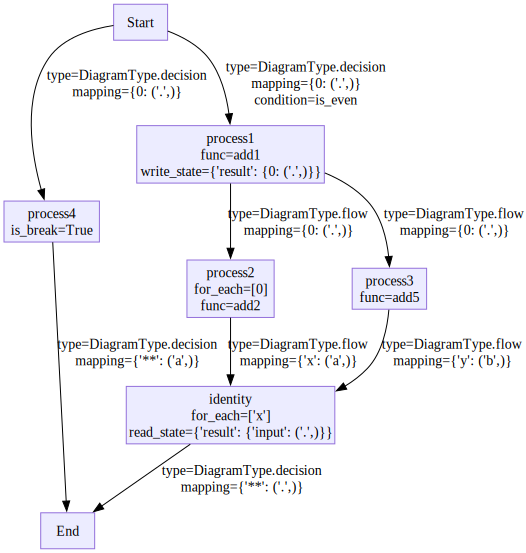

In [ ]:
with checkLogs(name='__main__'):
    with Define('test_d',type='decision',validate=False,draw=False,draw_raw=True) as TestD:
        V('process4',is_break=True)
        E('Start->process4')
        E('process4->End(**=a)')
        E('Start->process1',NamedLambda('is_even',lambda x: x%2==0))
        E('identity->End(**)')

        with Scope('flow'):
            V('process1',
                func=NamedLambda('add1',lambda x: x+1),
                outputs=['state/result'],)
            V('process2',
                func=NamedLambda('add2',lambda x: x+2),
                inputs=['process1'],
                for_each =[0]
                )
            V('process3',
                func=NamedLambda('add5',lambda x: x+5),
                inputs=['process1'],)
            V('identity',
                inputs=['process2(x=a)',
                        'process3(y=b)',
                        'state/result(input=.)',
                        ],
                for_each = ['x']
                        )


with Define('test_d2',type='decision',validate=False,draw=False,draw_raw=False) as TestD2:
    V('proc',TestD,
        inputs=['Start'],
        outputs=['End'],
    )




## Drawing diagrams

In [ ]:
#| export
from textwrap import indent
import re

In [ ]:
#| export
import ast
import inspect
import re

def _get_lambda_source(lambda_func):
    try:
        # Get the complete source lines containing the lambda
        source = inspect.getsource(lambda_func)
        
        # Find the lambda definition using regex
        lambda_match = re.search(r'(lambda\s+[^:]+:[^,\n\]})]+)', source)
        if lambda_match:
            lambda_str = lambda_match.group(1)
            
            # Validate and clean the lambda string using ast
            try:
                ast.parse(lambda_str)
                # Strip 'lambda' and whitespace around parameters
                lambda_str = re.sub(r'lambda\s+', '', lambda_str)
                return lambda_str
            except SyntaxError:
                pass
                
    except Exception:
        pass
    
    return 'Unparseable lambda'

In [ ]:
#| export

def _get_func_name(func):
    if isinstance(func,(types.FunctionType,types.MethodType)):
        if func.__name__ == '<lambda>':
            return _get_lambda_source(func)
        if hasattr(func,'__qualname__'):
            return func.__qualname__
        if hasattr(func,'__name__'):
            return func.__name__
    else:
        return str(func)

def _get_step_name(node_name,data):
    description_parts = []
    if 'func' in data:
        description_parts.append(_get_func_name(data['func']))
    if 'for_each' in data:
        description_parts.append(f'foreach=[{", ".join(map(str,data["for_each"]))}]')
    if 'filter' in data:
        description_parts.append('filter=True')
    if 'flat' in data:
        description_parts.append('flat=True')

    description = ', '.join(description_parts)
    if len(description) > 0:
        description = f'[ {description} ]'
    return f'{node_name}{description}'


def _accessor_to_string(accessor):
    if accessor is None:
        return ''
    return f'.'.join([str(acc) for acc in accessor])

def _mapping_to_string(mapping):
    if mapping == {0:('.',)}:
        return ''
    return ', '.join([f'{_accessor_to_string(v)} -> {k}' for k,v in mapping.items()])

def _condition_to_string(condition):
    if condition is None:
        return ''
    return f'?({_get_func_name(condition)})'

def _get_edge_string(u,v,data,mapping):
    condition = data.get('condition',None)
    mapping_string = _mapping_to_string(mapping)
    condition_string = _condition_to_string(condition)

    if len(mapping_string)> 0 and len(condition_string) > 0:
        condition_string += ': '

    if len(mapping_string) == 0 and len(condition_string) == 0:
        return None

    return f'{condition_string}{mapping_string}'




In [ ]:
#| export 


class NodeMapper():
    def __init__(self):
        self.counter = itertools.count()
        self.item_to_id = {}

    def __getitem__(self,item):
        if item not in self.item_to_id:
            self.item_to_id[item] = f'node_{next(self.counter)}'
        return self.item_to_id[item]    

    def __contains__(self,item):
        return item in self.item_to_id

In [ ]:
#| export
def _diagram_to_graphviz_data(g):
    
    node_mapper = NodeMapper()
    node_data_list = []
    edge_data_list = []

    for node,data in g.nodes(data=True):
        node_id = node_mapper[node]
        step_description = _get_step_name(node,data)
        is_break = data.get('is_break',False)
        is_stream = len(data.get('for_each',[])) > 0

        style = 'solid,filled'
        if is_break:
            style = 'dashed,filled'
        elif is_stream:
            style = 'bold,filled'

        node_data= {
            'name': node_id,
            'label': step_description,
            'shape': 'box',
            'style': style,
        }

        node_data_list.append(node_data)

        for key,mapping in data.get('read_state', {}).items():
            state_edge_name = _mapping_to_string(mapping)

            state_node_name = f'state_{key}'
            new_state = not state_node_name in node_mapper
            state_node_id = node_mapper[state_node_name]
            if new_state:
                node_data_list.append({
                    'name': state_node_id,
                    'label': f'State[{key}]',
                    'shape': 'cylinder',
                    'style': 'solid,filled',
                })
            edge_data_list.append({
                'tail_name': state_node_id,
                'head_name': node_id,
                'label': state_edge_name,
                'style': 'dashed',
            })
                
        
        for key,mapping in data.get('write_state', {}).items():
            state_edge_name = _mapping_to_string(mapping)

            state_node_name = f'state_{key}'
            new_state = not state_node_name in node_mapper
            state_node_id = node_mapper[state_node_name]
            if new_state:
                node_data_list.append({
                    'name': state_node_id,
                    'label': f'State[{key}]',
                    'shape': 'cylinder',
                    'style': 'solid,filled',
                })
            edge_data_list.append({
                'tail_name': node_id,
                'head_name': state_node_id,
                'label': state_edge_name,
                'style': 'dashed',
            })


    for u,v,data in g.edges(data=True):
        edge_mapping = data['mapping']
        edge_name = _get_edge_string(u,v,data,edge_mapping)
        
        if data['type'] == DiagramType.flow:
            style = 'solid'
            color = 'black'
        else:
            style = 'bold'
            color = 'blue'
        edge_data_list.append({
            'tail_name': node_mapper[u],
            'head_name': node_mapper[v],
            'label': edge_name,
            'style': style,
            'color': color,
        })
    
    return node_data_list,edge_data_list
    

In [ ]:
node_data_list,edge_data_list = _diagram_to_graphviz_data(TestD.graph)
node_data_list,edge_data_list


([{'name': 'node_0',
   'label': 'process4',
   'shape': 'box',
   'style': 'dashed,filled'},
  {'name': 'node_1',
   'label': 'Start',
   'shape': 'box',
   'style': 'solid,filled'},
  {'name': 'node_2', 'label': 'End', 'shape': 'box', 'style': 'solid,filled'},
  {'name': 'node_3',
   'label': 'process1[ add1 ]',
   'shape': 'box',
   'style': 'solid,filled'},
  {'name': 'node_4',
   'label': 'State[result]',
   'shape': 'cylinder',
   'style': 'solid,filled'},
  {'name': 'node_5',
   'label': 'identity[ foreach=[x] ]',
   'shape': 'box',
   'style': 'bold,filled'},
  {'name': 'node_6',
   'label': 'process2[ add2, foreach=[0] ]',
   'shape': 'box',
   'style': 'bold,filled'},
  {'name': 'node_7',
   'label': 'process3[ add5 ]',
   'shape': 'box',
   'style': 'solid,filled'}],
 [{'tail_name': 'node_3',
   'head_name': 'node_4',
   'label': '',
   'style': 'dashed'},
  {'tail_name': 'node_4',
   'head_name': 'node_5',
   'label': '. -> input',
   'style': 'dashed'},
  {'tail_name': 'no

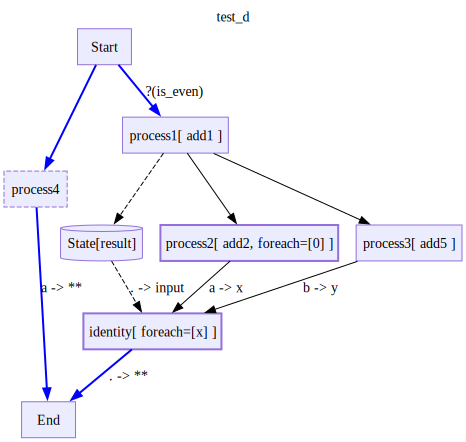

In [ ]:

dot = draw_graphviz(node_data_list,edge_data_list,
    name=TestD.name,direction='TB',
    node_attrs={'shape':'box','color':'#9370DB','fillcolor':'#ECECFF','style':'filled'}
    ,edge_attrs={},graph_attrs={})
dot

#TODO from here make this work with the draw_diagram interface

In [ ]:
#| export
def diagram_to_dot_single(graph,name,direction='TB',**kwargs):
    
    node_data_list,edge_data_list = _diagram_to_graphviz_data(graph)
    dot = draw_graphviz(node_data_list,edge_data_list,
        name=name,direction=direction,
        node_attrs={'shape':'box','color':'#9370DB','fillcolor':'#ECECFF'}
        ,edge_attrs={},graph_attrs={},**kwargs)
    return dot

def _match_any(name,patterns):
    for pattern in patterns:
        if re.match(pattern,name):
            return True
    return False


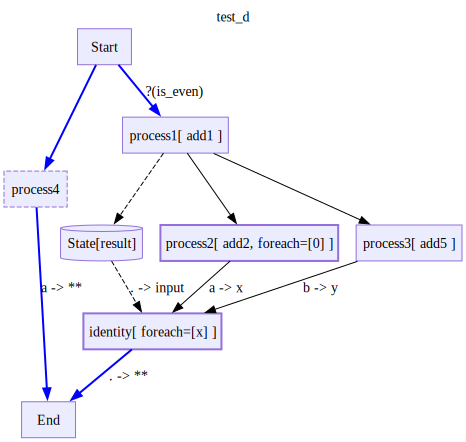

In [ ]:
diagram_to_dot_single(TestD.graph,TestD.name)

In [ ]:
#| export

def _diagram_to_dot_recursive(diagram,
    name=None,
    direction='TB',
    recursive: Union[bool,List[str]]=False,
    factored=False,
    **kwargs
    ):

    # if draw_compressed is True, draw the compressed graph
    # and add all recrusive names to the list of recrusive names to draw
    # 
    if factored:
        g = diagram.factored_graph
    else:
        g = diagram.graph

    if recursive is True:
        recursive = ['.*']
    elif recursive is False:
        recursive = []

    if name is None:
        name = diagram.name

    dot_per_diagram = {}

    dot_per_diagram[name] = diagram_to_dot_single(g,name,direction=direction,**kwargs)
    

    if factored or recursive:
        g_functions  = {node:data.get('func',None) for node,data in g.nodes(data=True)}
        for node,func in g_functions.items():
            if isinstance(func,Diagram):
                should_draw = _match_any(node,recursive) or (factored and func.anon)
                if should_draw:
                    sub_diagram_dots = _diagram_to_dot_recursive(func,name=None,direction=direction,
                                        recursive=recursive,factored=factored)
                    dot_per_diagram = dot_per_diagram | sub_diagram_dots

    return dot_per_diagram

def draw_diagram(diagram,
    name=None,
    return_dot=False,
    direction='TB',
    recursive: Union[bool,List[str]]=False,
    factored=False,
    **kwargs
    ):
    """Draw a diagram using graphviz.
    kwargs are sent to wrap to constrain node and edge labels
    
    Args:
        diagram: Either a diagram object or a diagram scheme object
        name: If provided, uses this name for the diagram in the Mermaid title
        return_dot: If True, returns the graphviz dot object
        direction: direction to draw, either TB (top to bottom) or LR (left to right), defaults to TB
        recursive: Whether to draw subdiagrams as well. 
            If False, only the top level diagram is drawn.
            If True, all subdiagrams are drawn.
            If a list of strings, only the subdiagrams with whose names the regex strings are drawn.
        factored: If True, draws the factored graph, used for debugging
    Returns:
        If return_dot is True, returns dot objects
        Otherwise displays diagram when in an Ipython environment
       
    """

    default_kwargs = {
        'width':20,
        'break_long_words':False,
        'replace_whitespace':False,
    }
    

    dot_per_diagram = _diagram_to_dot_recursive(diagram,name,direction,recursive,factored,**(default_kwargs|kwargs))
  
    if return_dot:
        if recursive or factored:
            return dot_per_diagram
        else:
            return list(dot_per_diagram.values())[0]
        
    for name,dot in dot_per_diagram.items():
        display_in_ipython(dot)
    

### Tests

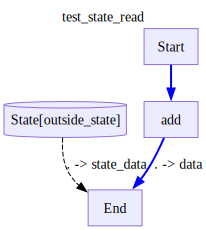

In [ ]:
with Define('test_state_read',type='decision',validate=False) as TestStateRead:
    V('add',inputs=['Start'],outputs=['End(data=.)'])
    E('state/outside_state->End(state_data=.)')

In [ ]:
_diagram_to_graphviz_data(TestStateRead.graph)

([{'name': 'node_0', 'label': 'add', 'shape': 'box', 'style': 'solid,filled'},
  {'name': 'node_1',
   'label': 'Start',
   'shape': 'box',
   'style': 'solid,filled'},
  {'name': 'node_2', 'label': 'End', 'shape': 'box', 'style': 'solid,filled'},
  {'name': 'node_3',
   'label': 'State[outside_state]',
   'shape': 'cylinder',
   'style': 'solid,filled'}],
 [{'tail_name': 'node_3',
   'head_name': 'node_2',
   'label': '. -> state_data',
   'style': 'dashed'},
  {'tail_name': 'node_0',
   'head_name': 'node_2',
   'label': '. -> data',
   'style': 'bold',
   'color': 'blue'},
  {'tail_name': 'node_1',
   'head_name': 'node_0',
   'label': None,
   'style': 'bold',
   'color': 'blue'}])

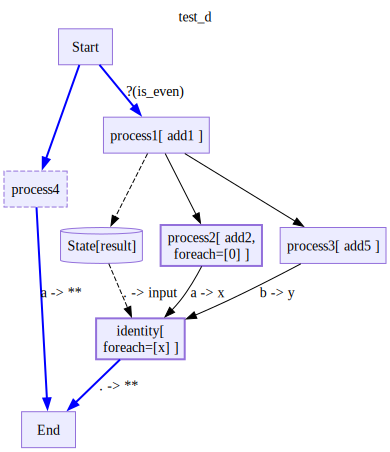

In [ ]:
draw_diagram(TestD)

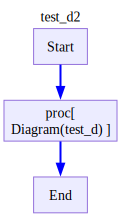

In [ ]:
draw_diagram(TestD2,recursive=True)


## Factoring diagrams into nested single type diagrams

In [ ]:
#| export

def _assert_single_edge_type(graph,node):
    in_edge_types = set(d['type'] for u,v,d in graph.in_edges(node,data=True))
    out_edge_types = set(d['type'] for u,v,d in graph.out_edges(node,data=True))
    if len(in_edge_types) > 1 or len(out_edge_types) > 1:
        raise ValueError(f"Node {node} has multiple edge types: in edge types '{in_edge_types}' and out edge types '{out_edge_types}'")

def _get_edge_type(graph,node,input_edge=False,output_edge=False):
    if input_edge:
        edges_data = [d for u,v,d in graph.in_edges(node,data=True)]
    elif output_edge:
        edges_data = [d for u,v,d in graph.out_edges(node,data=True)]
    if len(edges_data) == 0:
        return None
    return edges_data[0]['type']

def _has_different_edge_type(graph,node,edge_type,input_edge=False,output_edge=False):
    node_edge_type = _get_edge_type(graph,node,input_edge=input_edge,output_edge=output_edge)
    if node_edge_type is None:
        return False
    else:
        return node_edge_type != edge_type


def _subgraph_by_edge_type(graph,edge_type):
    return nx.edge_subgraph(graph,[(u,v) for u,v,d in graph.edges(data=True) if d['type'] == edge_type])

def _get_reachable_nodes(graph,node,reversed=False,bidirectional=False):
    if bidirectional:
        undirected_graph = graph.to_undirected()
        return set(nx.descendants(undirected_graph,node)).union({node})
    if reversed:
        return set(nx.ancestors(graph,node)).union({node})
    else:
        return set(nx.descendants(graph,node)).union({node})


def _replace_subgraph_with_node(g,subgraph,node_name,node_attrs):
    g.add_node(node_name,**node_attrs)
    # if there is an edge from a node in subgraph to a node not in subgraph, add an edge from node_name to that node    
    for u,v,d in list(g.edges(data=True)):
        if u in subgraph.nodes() and v not in subgraph.nodes():
            g.add_edge(node_name,v,**d)
        elif v in subgraph.nodes() and u not in subgraph.nodes():
            g.add_edge(u,node_name,**d)
        
        # self edges between nodes in the subgraph that are not part of the subgraph, ie the subgraph is a self loop
        elif u in subgraph.nodes() and v in subgraph.nodes() and (u,v) not in subgraph.edges():
            g.add_edge(node_name,node_name,**d)
    
    # remove all edges in subgraph
    g.remove_nodes_from(list(subgraph.nodes()))
    return g



def _cast_to_diagram(uncompressed_g,compressed_g,start_node,end_node,diagram_type=DiagramType.decision):
    if diagram_type == DiagramType.decision:
        d = DecisionDiagram(uncompressed_g,compressed = compressed_g,start_node=start_node,end_node=end_node)
        _validate_diagram_compressed(d)
    elif diagram_type == DiagramType.flow:
        d = FlowDiagram(uncompressed_g,compressed = compressed_g,start_node=start_node,end_node=end_node)
        _validate_diagram_compressed(d)
    else:
        d = Diagram(uncompressed_g,compressed = compressed_g,start_node=start_node,end_node=end_node)
    return d


In [ ]:
#| export
def compress_cuts(g,start_node,end_node,ret_raw_graph=False,wrap_as_diagram=False):

    orig_g = g
    g = deepcopy(g)


    logger.debug(f"Compressing graph with nodes {list(g.nodes())}")
    # note that each node can have a single type of input edges and a single type of output edges
    # the current_edge_type is the output type of the start node
    current_edge_type = _get_edge_type(g,start_node,output_edge=True)
    logger.debug(f"Current edge type is {current_edge_type}")
    
    # get the subgraph induced by all nodes of the current edge type, lets call it outer_graph
    outer_graph = _subgraph_by_edge_type(g,current_edge_type)
    logger.debug(f"current cut includes nodes {list(outer_graph.nodes())} and edges {list(outer_graph.edges())}")
    
    # if all edges in graph are in cut return the diagram
    if len(outer_graph.edges()) == len(g.edges()):
        logger.debug("All edges in graph are in cut")
        # we are done ,and we can move to the validation step
        if wrap_as_diagram:
            return Diagram(graph=g,factored_graph=g,start_node=start_node,end_node=end_node,type=current_edge_type),current_edge_type
        else:
            return g,current_edge_type

    # otherwise, we have a possible nested inner cut
    reachable_from_start = _get_reachable_nodes(outer_graph,start_node)
    reachable_from_end = _get_reachable_nodes(outer_graph,end_node,reversed=True)
    logger.debug(f"Reachable from start {reachable_from_start}")
    logger.debug(f"Reachable from end {reachable_from_end}")

    # sub_cut_entries are all nodes reachable from the start node in cut
    # whose output edge is of a different type in the main graph
    sub_cut_entries = set(node for node in reachable_from_start if _has_different_edge_type(g,node,current_edge_type,output_edge=True))
    logger.debug(f"Sub cut entries are {sub_cut_entries}")
    # sub_cut_exits are all nodes that are reachable in the inverse dirction from end 
    # and have an input edge of a different type in the main graph
    sub_cut_exits = set(node for node in reachable_from_end if _has_different_edge_type(g,node,current_edge_type,input_edge=True))
    logger.debug(f"Sub cut exits are {sub_cut_exits}")
    
    # current cut nodes, are nodes reachable from both start and end by traversing the Cut, 
    # that are not sub_cut_entries or sub_cut_exits
    
    # all nodes between that are not sub_cut_entries or sub_cut_exits or reachable from start without going through end
    bi_directional_reachable_nodes = (
            _get_reachable_nodes(outer_graph,start_node,bidirectional=True) | 
            _get_reachable_nodes(outer_graph,end_node,bidirectional=True)
            )
    outer_scope_nodes = bi_directional_reachable_nodes - sub_cut_entries - sub_cut_exits
    logger.debug(f"outer scope nodes are {outer_scope_nodes}")
    # now we need to figure out which sub_cut_entries map to sub_cut_exits
    # if they are not the same length, this is an error, but we need to find the nodes that are causing the error

    # the inner graph, is the graph without the current cut nodes, and without the edges from sub_cut_exits to sub_cut_entries
    edges_from_ends_to_starts = {(u,v) for u,v in g.edges() if u in sub_cut_exits and v in sub_cut_entries}
    inner_graph = g.subgraph(g.nodes() - outer_scope_nodes).copy()
    inner_graph.remove_edges_from(edges_from_ends_to_starts)
    logger.debug(f"Inner graph has nodes {list(inner_graph.nodes())} and edges {list(inner_graph.edges())}")
    
    # for our diagram to be well defined, each sub_cut_entry must have a unique sub_cut_exit reachable from it in the inner graph
    # for each sub_cut_entry, we compute it's reachable nodes in the inner graph, filter them to include only the sub_cut_exits
    exits_per_entry ={
        entry:set(nx.descendants(inner_graph,entry)) & sub_cut_exits
        for entry in sub_cut_entries
    }
    logger.debug(f"Exits per entry {exits_per_entry}")

    
    # if there are any sub_cut_entries that have no sub_cut_exits or more than one, we collect all of them and raise an error message

    entries_with_wrong_number_of_exits = set()
    for entry,exists in exits_per_entry.items():
        if len(exists) == 0 or len(exists) > 1:
            entries_with_wrong_number_of_exits.add(entry)
    if len(entries_with_wrong_number_of_exits) > 0:
        wrong_entries_dict = {entry:exists for entry,exists in exits_per_entry.items() if entry in entries_with_wrong_number_of_exits}
        raise ValueError(
            f"Trying to compress diagram with nodes {list(g.nodes())}, whose main type is {current_edge_type}",
            f"found the following nodes that are defined within a nested scope {list(inner_graph.nodes())}",
            f"The following entries have no exits or more than one exit: {wrong_entries_dict}"
            )

    
    # now, if we are here, we have a list of sub_cut_entries and sub_cut_exits pairs.
    # they should be disjoint, meaning no node should be reachable from 2 starts or from 2 ends

    entry_exit_pairs = [
        (entry,list(exits)[0]) for entry,exits in exits_per_entry.items()
    ]
    logger.debug(f"Entry exit pairs {entry_exit_pairs}")

    # for each such pair,
    sub_diagrams = []
    sub_graphs = []
    for entry,exit in entry_exit_pairs:
        # their induced subdiagram is the inner graph induced on all nodes reachable from the entry node

        sub_graph = inner_graph.subgraph(nx.descendants(inner_graph,entry) | {entry})
        sub_graphs.append(sub_graph)
        logger.debug(f"Processing subcut with start node '{entry}' and end node '{exit}'\n"
                     f"Sub graph has nodes {list(sub_graph.nodes())} and edges {list(sub_graph.edges())}"
                     f"Calling compress_cuts on it"
                     )
        #  make a recursive call to compress_cuts on the induced subdiagram
        sub_diagram,_ = compress_cuts(sub_graph,entry,exit,ret_raw_graph=ret_raw_graph,wrap_as_diagram=True)
        sub_diagrams.append(sub_diagram)
    
        
    # assuming the recursive calls succeeded, 
    # compress the graph by replacing each sub_graph with a node that has the sub_diagram as its function
    for sub_graph,sub_diagram,(entry,exit) in zip(sub_graphs,sub_diagrams,entry_exit_pairs):
        sub_diagram.anon = True
        logger.debug(f"Replacing sub graph {list(sub_graph.nodes())} with node {f'{entry}->{exit}_diagram'}")

        sub_diagram.name = f'anon_from_{entry}_to_{exit}'
        g=_replace_subgraph_with_node(g,sub_graph,sub_diagram.name,{'func':sub_diagram})
        logger.debug(f"After replacement, graph has nodes {list(g.nodes())} and edges {list(g.edges())}")

    # return the compressed graph as a diagram of the current edge type
    if wrap_as_diagram:
        return Diagram(orig_g,factored_graph=g,start_node=start_node,end_node=end_node,type=current_edge_type),current_edge_type
    else:
        return g,current_edge_type



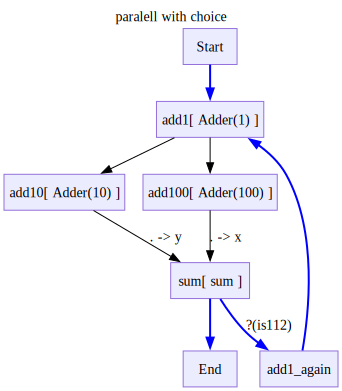

In [ ]:
class Adder():
    def __init__(self,x):
        self.x = x

    def __call__(self,y):
        return self.x + y

    def __repr__(self):
        return f'Adder({self.x})'

sum = NamedLambda('sum',sum)

is112 = NamedLambda('is112',lambda x: x == 112)

with Define('paralell with choice',type='decision',validate=False) as d:

    V('add1',Adder(1),inputs=['Start'])
    with Scope('flow'):
        V('add10',Adder(10),inputs=['add1'])
        V('add100',Adder(100),inputs=['add1'])
        V('sum',sum,inputs=['add10(y=.)','add100(x=.)'])


    E('sum->End')
    E('sum->add1_again',cond=is112)
    E('add1_again->add1')

    #EXPLAIN what are legal parallel cut

In [ ]:
with checkLogs(name='__main__'):
    d.factored_graph,_ = compress_cuts(d.graph,'Start','End')


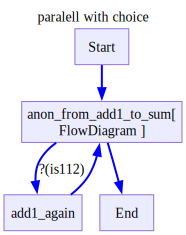

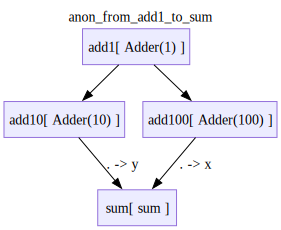

In [ ]:
draw_diagram(d,factored=True)

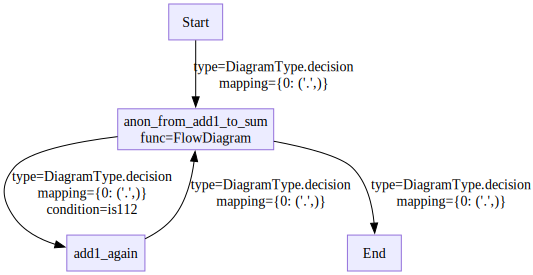

In [ ]:
draw_nx(d.factored_graph)


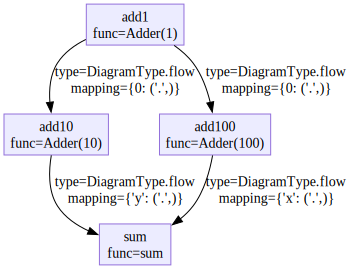

In [ ]:
draw_nx(d.factored_graph.nodes['anon_from_add1_to_sum']['func'].factored_graph)

In [ ]:
with checkLogs(name='__main__'):
    TestD.factored_graph,_ = compress_cuts(TestD.graph,'Start','End')


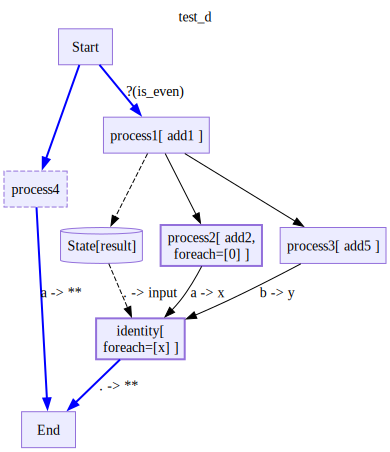

In [ ]:
draw_diagram(TestD,factored=False)


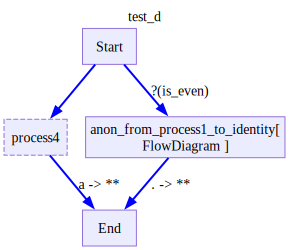

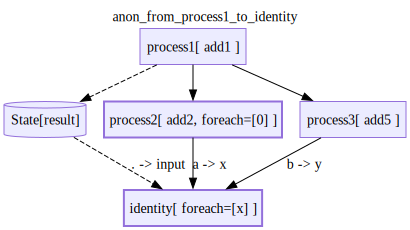

In [ ]:
draw_diagram(TestD,factored=True)


## Validation of diagrams

In [ ]:
#| export

validate_logger = logging.getLogger(f'{__name__}.validate')

def _validate_diagram_unfactored(diagram):
    
    g = diagram.graph

    validate_logger.debug(f"Validating unfactored diagram {diagram.name}")

    def get_father_target_ports(father,node):
        edge_data = g.edges[father,node]
        target_ports = edge_data.get('mapping',{}).keys()
        return list(target_ports)




    # make sure all nodes have a single edge type
    for node,data in g.nodes(data=True):
        _assert_single_edge_type(g,node)

    validate_logger.debug(f"All nodes have a single edge type")

    for node in g.nodes():
        
        input_state_ports = list(g.nodes[node].get('read_state',{}).keys())
        input_edge_type = _get_edge_type(g,node,input_edge=True)

        if input_edge_type == DiagramType.decision:
            for father_node,_,edge_data in g.in_edges(node,data=True):
                father_target_ports = list(edge_data.get('mapping',{}).keys())
                # if there is an overlap between the father_target_ports and the input_state_ports, raise an error
                intersection = set(father_target_ports).intersection(input_state_ports) 
                if intersection:
                    raise ValueError(f"Node {node} has the conflicting input ports '{intersection}' \n"
                                    f" in both its state and its father node {father_node}\n"
                                    )
                union = set(father_target_ports).union(input_state_ports)
                if not assert_keys_contiguous(union):
                    raise ValueError(f"Node {node}'s input key are not contiguos (0,1,2,3... without gaps) when coming from:\n"
                                    f"{father_node} and state\n"
                                    f"The input keys are {union}"
                                    )

        elif input_edge_type == DiagramType.flow:
            # for flow inputs we check all incoming nodes together
            port_set_per_father = {
                'input_state_ports':input_state_ports,
            }
            
            for father,_,edge_data in g.in_edges(node,data=True):
                father_target_ports = list(edge_data.get('mapping',{}).keys())
                port_set_per_father[father] = father_target_ports
            
            duplicate_ports = _duplicates(port_set_per_father.values())
            if len(duplicate_ports) > 0:
                raise ValueError(f"Node {node} has conflicting input ports '{duplicate_ports}'\n"
                                 f"between its father nodes and/or state {port_set_per_father}")
            union = set(input_state_ports)
            for father_ports in port_set_per_father.values():
                union = union.union(set(father_ports))
            if not assert_keys_contiguous(union):
                raise ValueError(f"Node {node}'s input key are not contiguos (0,1,2,3... without gaps) when coming from:\n"
                                f"{port_set_per_father}\n"
                                f"The input keys are {union}"
                                )


    start_node = diagram.start_node
    end_node = diagram.end_node

    if not nx.has_path(g,start_node,end_node):
        raise ValueError(f"Diagram {diagram.name} has no path from start node {start_node} to end node {end_node}")

    no_input_nodes = {node for node in g.nodes() if len(g.in_edges(node)) == 0}
    if no_input_nodes!={start_node}:
        extra_nodes = no_input_nodes-{start_node}
        raise ValueError(f"Diagram {diagram.name} has unreachable nodes with no input edges except for the start node({start_node}): {extra_nodes}")





In [ ]:
# Handling state conflicts
# flow nodes cant write state if they have a non one mutiplicity
# or if there is another node that reads or writes the same state

# for nested anonymous diagrams, where state is shared, we need an ownership mechanism
# each subdiagram has who it reads and writes to, and we need to make sure that there are no multiplicities except multiple readers at once.

# also, we need to figure out how to avoid sharing states between a subdiagram that is used twice in a flow diagram. we need to make copies of the diagram for each one.

# currently, to start, I won't allow writing to shared state within a flow diagram.
# this is done by checking read_keys and write_keys on the unfactored graph

In [ ]:
#|export
def _validate_diagram_factored(diagram):
    graph = diagram.factored_graph
    
    # we keep for each node in the unfactored graph, the nested node in the factored graph
    # it corresponds to.
    nodes_to_nested_nodes = {node:[node] for node in graph.nodes}

    # validate all anonymous subdiagrams recursively
    anon_sub_diagrams = []
    for node,node_data in graph.nodes(data=True):
        func = node_data.get('func',None)
        if isinstance(func,DiagramSchema) and func.anon:
            sub_diag_nested_nodes = _validate_diagram_factored(func)
            for sub_node,sub_nested_nodes in sub_diag_nested_nodes.items():
                nodes_to_nested_nodes[sub_node] = [node] + sub_nested_nodes


    match diagram.type:
        case DiagramType.flow:
            _validate_flow_diagram(diagram)
        case DiagramType.decision:
            _validate_decision_diagram(diagram)


    # for each node, compute its port mappings dict of the form {'father_node':mapping_dict}
    for node,node_data in graph.nodes(data=True):
        port_mappings = {}
        # regular father mappings
        for father,_,edge_data in graph.in_edges(node,data=True):
            port_mappings[father] = edge_data.get('mapping',{})
        # read state mappings
        for key,mapping in node_data.get('read_state',{}).items():
            port_mappings[('state',key)] = mapping
        node_data['mapping'] = port_mappings
        validate_logger.debug(f"Port mapping for node {node}:{dict(port_mappings)}")


    # TODO is this still neccessary?
    # copy all subdiagrams so that we dont share state between them
    for node,node_data in graph.nodes(data=True):
        func = node_data.get('func',None)
        if isinstance(func,Diagram):
            node_data['func'] = copy(func)

    diagram.nodes_to_nested_nodes = nodes_to_nested_nodes
    return nodes_to_nested_nodes



def _validate_flow_diagram(diagram):
    graph = diagram.factored_graph
    if diagram.has_breakpoints:  
        raise ValueError(f"Breakpoints are not allowed in a Flow diagram ({diagram.name})")

    if len(diagram.write_keys) > 0:
        raise ValueError(f"Flow diagrams cannot have write keys, but diagram {diagram.name} has write keys {diagram.write_keys}")

    # make sure that ends of flow diagrams are not mapped, meaning they collect all their inputs
    if graph.nodes[diagram.end_node].get('for_each',list()) != []:
        raise ValueError(f"End node {diagram.end_node} of flow diagram {diagram.name} is cannot have for_each inputs.\n"
                        f"The end of the flow diagram must be a single node that collects all its inputs into a single output")


    # for each node we compute the for_each_fathers. The fathers that have foreach ports
    for node,node_data in graph.nodes(data=True):
        for_each_ports = node_data.get('for_each',list())
        for_each_fathers = set()
        regular_fathers = set()
        for father,_,edge_data in graph.in_edges(node,data=True):
            target_port = edge_data.get('target_port',None)
            if isinstance(target_port,tuple):
                for port in target_port:
                    if port in for_each_ports:
                        for_each_fathers.add(father)
                    else:
                        regular_fathers.add(father)
            else:
                if target_port in for_each_ports:
                    for_each_fathers.add(father)
                else:
                    regular_fathers.add(father)
        node_data['regular_fathers'] = regular_fathers
        node_data['for_each_fathers'] = for_each_fathers


    

def _validate_decision_diagram(diagram):
   
    graph = diagram.factored_graph


    for node,data in graph.nodes(data=True):
        out_edges = list(graph.out_edges(node,data=True))
        edges_without_condition = [ (s,t,d) for s,t,d in out_edges if d.get('condition',None) is None]
        if len(edges_without_condition) > 1:
            clean_edges = [(s,t) for s,t,d, in edges_without_condition]
            raise ValueError(f"In a Decision diagram, Node {node} cannot have multiple output edges with no condition\n"
                            f"Currenlty, edges {clean_edges} do not have a condition.\n")
        
        if node == diagram.end_node:
            continue
        # check that all nodes except the End node have an output edge.
        if len(list(graph.out_edges(node,data=False))) == 0:
            raise ValueError(f"Node {node} must have an output edge, since it is not the end node.\n"
                            f"In diagram {diagram.name}"
            )



In [ ]:
#| export
@patch
def post_def(self:DiagramSchema):
    '''
    validate the graph and factor it
    '''
    logger.debug(f"Post def for diagram {self.name}")
    _validate_diagram_unfactored(self)
    self.factored_graph,self.type = compress_cuts(self.graph,self.start_node,self.end_node)
    _validate_diagram_factored(self)
    


### Test

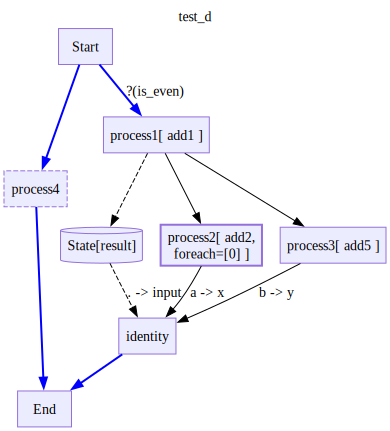

In [ ]:
with checkLogs(name='__main__'):
    with Define('test_d',type='decision',validate=False) as TestD:
        V('process4',is_break=True)
        E('Start->process4')
        E('process4->End')
        E('Start->process1',cond=NamedLambda('is_even',lambda x: x%2==0))
        E('identity->End')

        with Scope('flow'):
            V('process1',
                func=NamedLambda('add1',lambda x: x+1),
                outputs=['state/result'],)
            V('process2',
                func=NamedLambda('add2',lambda x: x+2),
                inputs=['process1'],
                for_each =[0]
                )
            V('process3',
                func=NamedLambda('add5',lambda x: x+5),
                inputs=['process1'],)
            V('identity',
                inputs=['process2(x=a)',
                        'process3(y=b)',
                        'state/result(input=.)',
                        ],
                        )

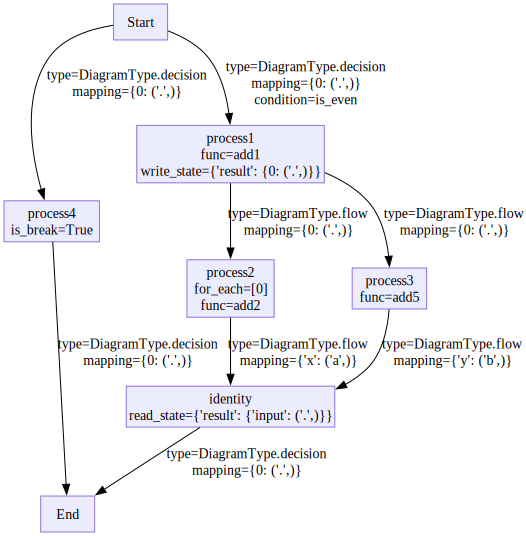

In [ ]:
display(draw_nx(TestD.graph))

In [ ]:
TestD.post_def()

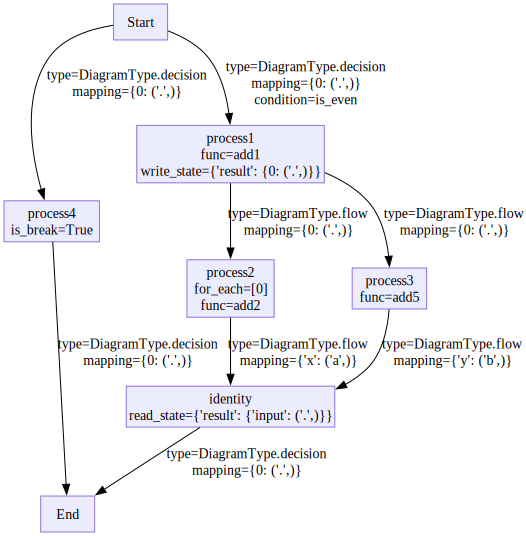

In [ ]:
display(draw_nx(TestD.graph))

In [ ]:
assert TestD.nodes_to_nested_nodes == {'process4': ['process4'],
 'Start': ['Start'],
 'End': ['End'],
 'anon_from_process1_to_identity': ['anon_from_process1_to_identity'],
 'process1': ['anon_from_process1_to_identity', 'process1'],
 'identity': ['anon_from_process1_to_identity', 'identity'],
 'process2': ['anon_from_process1_to_identity', 'process2'],
 'process3': ['anon_from_process1_to_identity', 'process3']}

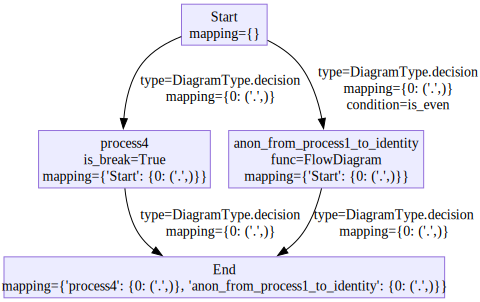

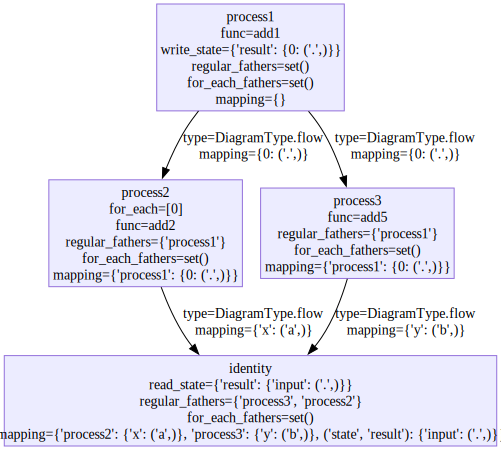

In [ ]:
display(draw_nx(TestD.factored_graph))
display(draw_nx(TestD.factored_graph.nodes['anon_from_process1_to_identity']['func'].factored_graph))

### Accessing nodes

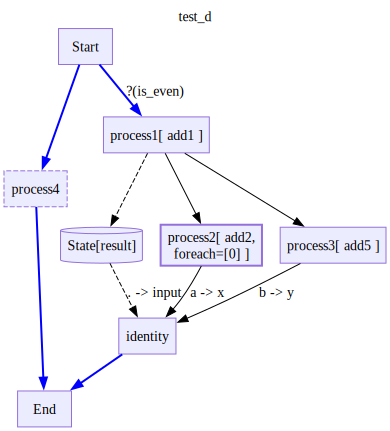

In [ ]:
draw_diagram(TestD)

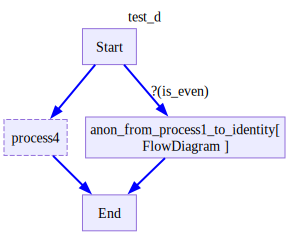

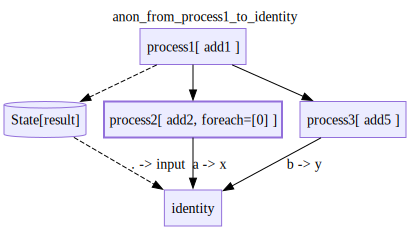

In [ ]:
draw_diagram(TestD,factored=True)

In [ ]:
inst = TestD(process2=NamedLambda('add3',lambda x: x+3))
draw_diagram(inst)
draw_diagram(inst,factored=True)


AttributeError: 'Diagram' object has no attribute 'nodes_to_nested_nodes'

## Execution functions

### Get and Set state

In [ ]:
#| export
@patch
def get_input_only_state_keys(self:DiagramSchema):
    nodes = self.graph.nodes
    input_state_keys = set()
    output_state_keys = set()
    for node in nodes:
        for key,port in nodes[node].get('read_state',{}).items():
            input_state_keys.add(key)
        for key,port in nodes[node].get('write_state',{}).items():
            output_state_keys.add(key)

    input_only_state_keys = input_state_keys - output_state_keys
    return input_only_state_keys


### node input output

In [ ]:
#| export

@patch
def _set_node_output(self:Diagram, node, output):
    # for each write state, get the output at the port position and set it to the state at based on the key
    graph = self.factored_graph
    for key,mapping in graph.nodes[node].get('write_state',{}).items():      
        object_to_write = simplify_output(map_object(output,mapping))
        logger.debug(f"Setting state '{key}' based on output {output}\n"
                    f"after mapping it to {object_to_write}\n"
                    f"with mapping {mapping}")
        set_state_key(self.state,key,object_to_write)



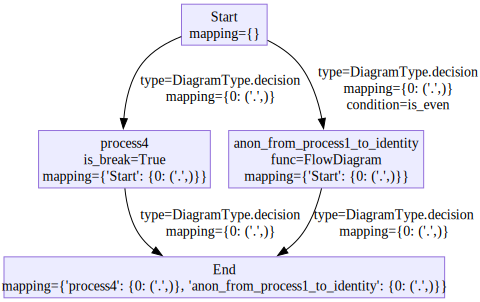

In [ ]:
draw_nx(TestD.factored_graph)

In [ ]:
#|export

@patch
def _get_state_input_keys(self:Diagram,node):
    return list(self.factored_graph.nodes[node].get('read_state',{}).keys())
@patch
def _get_state_input(self:Diagram,node):
    keys = self._get_state_input_keys(node)
    return {('state',key):simplify_output(get_state_key(self.state,key)) for key in keys}

@patch
def compute_node_input(self:Diagram,node,previous_outputs,state,raw_input=False,partial=False):
    """Prepare the input for the next node execution"""
    
    graph = self.factored_graph
    logger.debug(f"diagram {self.name} preparing input for node '{node}' based on previous outputs {previous_outputs}")

    port_mappings = graph.nodes[node]['mapping']

    state_objects = self._get_state_input(node)

    if raw_input:
        object_to_map = state_objects
    else:
        object_to_map = previous_outputs | state_objects

    func_input = multi_map(object_to_map,port_mappings)

    if raw_input:
        if isinstance(previous_outputs,dict):
            func_input = previous_outputs|func_input
        else:
            func_input = {0:simplify_output(previous_outputs)}|func_input

    logger.debug(f"diagram {self.name} for node '{node}' input prepared:{func_input}")

    return func_input


In [ ]:
#| export
@patch

def _before_node(self:Diagram,node,input_):
    
    # get input for the node
    # clear the input from the internal state
    graph = self.factored_graph
        
    # if we got a validator, validate the input
    self._validate_node_input(node,input_)
    

    func = graph.nodes[node].get('func',None)
    return func

@patch
def _after_node(self:Diagram,node,output):
    self._validate_node_output(node,output)
    # set the output to the outbound state
    self._set_node_output(node,output)
    return 

@patch
def _validate_node_input(self:Diagram,node,func_input):
    # get the input validator
    # if validator is basemodel, and there is only a singel arg, validate it
    # if validator is basemodel, and there are only kwargs, validate them as a dict
    # if validator is basemodel, and there are args and kwargs, log a warning

    # if validator is callable, run it on input as args and kwargs
    return 

@patch
def _validate_node_output(self:Diagram,node,output):
    # get the output validator
    # if validator is basemodel validate it against it
    # if validator is callable, run it on output as a single arg
    return 

### Traces

In [ ]:
#| export
from datetime import datetime
from typing import Optional
from pydantic import BaseModel, computed_field
from pprint import pprint
from typing import Dict,Any,Literal,Union,List

from pprint import pformat
from textwrap import indent

from pprint import PrettyPrinter
import reprlib


In [ ]:
#| export
class TruncatedPrettyPrinter(PrettyPrinter):
    def __init__(self, *args, str_length=100, **kwargs):
        super().__init__(*args, **kwargs)
        self.str_length = str_length

    def _format(self, obj, stream, indent, allowance, context, level):
        if isinstance(obj, str):
            if len(obj) > self.str_length:
                # Truncate string and add ...
                stream.write(repr(obj[:self.str_length] + '...'))
                return
        super()._format(obj, stream, indent, allowance, context, level)

In [ ]:
#| export
class Trace(BaseModel):
    model_config = {"arbitrary_types_allowed": True}
    run_uid: str
    node_uid: str
    node_name: List[str]
    input_idx: List[Union[int,None]] = [None]
    node_func: Optional[Any] = None
    input_state_keys: Optional[set[str]] = None
    input_: Any
    output: Optional[Any] = None
    run_type: DiagramType
    start_time: Optional[datetime] = None
    end_time: Optional[datetime] = None

    @computed_field
    def duration(self) -> Optional[datetime]:
        """Return the duration of the node execution in seconds"""
        if self.start_time is None or self.end_time is None:
            return None
        return (self.end_time - self.start_time).total_seconds()

    def nest(self,name,idx):
        self.node_name.insert(0,name)
        self.input_idx.insert(0,idx)

    def pretty_name(self):
        name_parts = []
        for name,idx in zip(self.node_name,self.input_idx):
            if idx is None:
                name_parts.append(name)
            else:
                name_parts.append(f"{name}[{idx}]")
        return '.'.join(name_parts)

    def pformat(self,show_input=True,show_output=True,show_input_state=True,depth=None,indent=2,width=80,str_max_length=None):

        data = {}
        
        if show_input_state == False and isinstance(printable_input,dict):
            printable_input = {k:v for k,v in self.input_.items() if k not in self.input_state_keys}
        else:
            printable_input = self.input_
    
        if show_input:
            data['input'] = printable_input
        if show_output:
            data['output'] = self.output

        if str_max_length is not None:
            pp = TruncatedPrettyPrinter(str_length=str_max_length,indent=indent,width=width,depth=depth)
        else:
            pp = PrettyPrinter(indent=indent,width=width,depth=depth)
        return pp.pformat(data)

    def write(self,string,file=None):
        if file is None:
            fptr = sys.stdout
        else:
            fptr = open(file,'a')
        fptr.write(string+'\n')
        if file is not None:
            fptr.close()

    def pprint(self,
        show_input=True,
        show_output=True,
        show_input_state=True,
        depth=None,
        indent=2,
        width=80,
        str_max_length=None,
        skip_passthrough=False,
        file=None):
        """
        Print the trace in a pretty format
        Args:
            show_input (bool, default=True): Whether to show the input data
            show_output (bool, default=True): Whether to show the output data 
            show_input_state (bool, default=True): Whether to show input state data
            depth (int, optional): Maximum depth to print nested structures
            indent (int, default=2): Number of spaces for each indentation level
            width (int, default=80): Maximum line width for pretty printing
            str_max_length (int, optional): Maximum length for string values before truncating
            skip_passthrough (bool, default=False): Whether to skip printing passthrough nodes (nodes with no function)
            file (str, optional): File to write the output to. Defaults to None. which prints to stdout
        """
        if skip_passthrough and self.node_func is None:
            return
        self.write(f'Node {self.pretty_name()}:',file=file)
        self.write(self.pformat(show_input,show_output,show_input_state,depth,indent,width,str_max_length),file=file)
        self.write('='*width,file=file)


In [ ]:
#| export
@patch
def prep_trace(self:Diagram,node,input_,output,type=DiagramType.decision,idx=None,start_time=None,end_time=None):
    
    graph = self.factored_graph
    return Trace(
        run_uid = self.run_uid,
        node_uid = str(uuid.uuid4()),
        node_name = [node],
        input_idx = [idx],
        node_func = graph.nodes[node].get('func',None),
        input_state_keys = self.get_input_only_state_keys(),
        input_ = input_,
        output = output,
        run_type = type,
        start_time = start_time,
        end_time = end_time
        )


### Running nodes

In [ ]:
#| export

def simplify_output(input_):
    if isinstance(input_,dict) and len(input_) ==1 and 0 in input_:
        output = input_[0]
    else:
        output = input_ 
    return output

@patch
async def run_node(self:Diagram,node,input_,idx=None):

    graph = self.factored_graph
    
    func = self._before_node(node,input_)
    
    logger.debug(f"Running node '{node}[{idx}]' with input {input_} and state {self.state}")
    if func is None:
        output = simplify_output(input_)
    else:
        args,kwargs = object_to_args_kwargs(input_)
        try:
            # run the node
            output = await maybe_await(func,args,kwargs)
        except Exception as e:
            raise ValueError(f"When running node '{node}[{idx}]':\n"
                f"Function {func}(args={args},kwargs={kwargs})\nreturned\nError '{e}'\n") from e

    logger.debug(f"{node}({input_})={output}")
    self._after_node(node,output) 
    return input_,output


@patch
async def run_subdiagram_iter(self:Diagram,node,input_,subdiagram,idx=None):
    """
    Run a subdiagram as a node
    yields traces from the subdiagram
    returns the output of the subdiagram and the subdiagram itself
    """
    graph = self.factored_graph

    _ = self._before_node(node,input_)

    func = subdiagram

    # run the sub diagram via its run method as an iterator,
    # yield traces from the sub diagram
    if self.derive_state:
        state = self.state
    else:
        state = None
    async for trace in subdiagram.arun(input_,state = state,progress_bars=self.progress_bars):
        # append the name of the node to the last node and nodes with a '.' delimiter
        if not self.trace_nested:
            # if we dont want nested trace print yielding them.
            continue
        if not subdiagram.anon:
            trace.nest(node,idx)
        yield trace

    # after the subdiagram is done, set the output to the outbound state
    self._after_node(node,subdiagram.output)
    return




### Run Decision Diagrams


In [ ]:
# we need to factor the port mapping out into a seperate function that works on mapping data.
# we save the mapping data during post_def
# we can check for conflicts in the mapping data based on the decision/flow semantics.
# and then we use it in the arun decision and arun flow functions

# this function should be in pos_kwargs syntax, we can probably simplify the function inputclass by just keeping the assert and the args kwargs as functions.
# when we are in decision, lets us a read_keys to output function
# and then just pass the mapping data with ('father_node','state') to the mapping
# in flow, we will paritally apply the mapping data to the input ports. as new fathers finish, ultimately merging stream and regular inputs.





In [ ]:
#| export

decision_logger = logging.getLogger(f'{__name__}.decision')

@patch
async def arun_decision(self:Diagram,input_,state,**kwargs):


    logger.debug(f"Running decision diagram {self.name} with input {input_}")
    if self.finished in [True,None]:
        self.finished = False
        current_node = self.start_node
    else:
        current_node = self.next_node

    graph = self.factored_graph
    # no need to map ports on iteration
    raw_input = True

    while True:
        func = graph.nodes[current_node].get('func',None)
        is_sub_diagram = isinstance(func,Diagram)
        is_anon_sub_diagram = is_sub_diagram and func.anon

        input_ = self.compute_node_input(current_node,input_,self.state,raw_input,partial=True)

        start_time = datetime.now()
        if is_sub_diagram:
            subdiagram = func
            async for trace in self.run_subdiagram_iter(current_node,input_,subdiagram,**kwargs):
                yield trace
            output = subdiagram.output
        else:
            _,output = await self.run_node(current_node,input_,**kwargs)
        # TODO the delta time should also work for sub diagrams with breakpoints, for the entire duration until they finished, excluding waiting time to continue.
        end_time = datetime.now()
        
        sub_dir_break = is_sub_diagram and subdiagram.finished == False

        raw_input = False
        if not (is_anon_sub_diagram or sub_dir_break):
            yield self.prep_trace(current_node,input_=input_,output=output,type=DiagramType.decision)

        if sub_dir_break:
            next_node = current_node
            logger.debug(f"Sub diagram {current_node} is not finished, will continue from it when run again")
        else:
            next_node = self.choose_next_node(current_node,output)
            logger.debug(f"Choosing next node after {current_node} with output {output}: {next_node}")
        
        is_end = next_node is None

        is_break = sub_dir_break or (not is_end and graph.nodes[next_node].get('is_break',False))

        # if we are at the end or a breakpoint,
        # prep for the next run and exit
        if is_end:
            self.finished = True
        if is_end or is_break:
            # set the output as the output of the last node we run
            saved_output = output
            
            self.output = simplify_output(output)
            # set the next node to run
            self.next_node = next_node
            return 
        
        input_ = {current_node:output}
        current_node = next_node

    logger.debug(f"Decision diagram {self.name} finished with output {self.output}")
    # should never get here
    return 


In [ ]:
#| export
@patch
def choose_next_node(self:Diagram,node,output):
    """
    Based on the output of the last node, choose the next node
    returns the next node to run, or None if we are at the end
    """

    graph = self.factored_graph
    if node ==self.end_node:
        return None

    # get a dict with each condition and its target node 
    # and get the default target node
    # based on the outgoing edges from the node

    out_going_edges = {target:data for source,target,data in graph.out_edges(node,data=True)}
    condition_per_target = {}
    for target,data in out_going_edges.items():
        if 'condition' in data:
            condition_per_target[target] = data['condition']
        else:
            default_target = target
    logger.debug(f"Condition per target for node '{node}': {condition_per_target}")
    # run the condition functions of each target node on the output
    condition_results = {}
    for target,condition_func in condition_per_target.items():
        try:
            condition_result = condition_func(output)
        except Exception as e:
            raise ValueError(f"When choosing next node after {node}:\n"
                f"Condition function {condition_func}({output}) returned \n{type(e).__name__}:'{e}'"
                ).with_traceback(e.__traceback__)

        # if any condition function returned something other than a boolean, raise an error
        if not isinstance(condition_result,bool):
            raise ValueError(f"When choosing next node after {node}:\n"
                f"Condition function {condition_func} returned {condition_result} which is not a boolean when evaluated on output {output}")
        condition_results[target] = condition_result

    logger.debug(f"Condition results for node '{node}' with output {output}: {condition_results}")
    # if there are more than 2 trues
        # raise an error
    num_trues = sum(condition_results.values())
    if num_trues > 1:
        raise ValueError(f"When choosing next node after {node}:\n"
            f"More than one condition function succeeded when evaluated on output {output}"
            f"condition results: {condition_results}"
            )
    # if there is one true, return the target node of that condition
    elif num_trues == 1:
        chosen_target = next(target for target,result in condition_results.items() if result)
    # if there are no trues, return the default target
    else:
        chosen_target = default_target
    
    return chosen_target



### Run Flow Diagrams


In [ ]:
#| export
from stringdale.core import (
    new_combinations,
    merge_list_dicts,
    dict_cartesian_product
    )

In [ ]:
#| export

flow_logger = logging.getLogger(f'{__name__}.flow')


async def _wait_for_tasks( tasks):
    """Wait for any task to complete from any of the task dictionaries"""
    all_tasks = (*tasks['regular'],*tasks['iterator'],*tasks['subdiagram'])
    if not all_tasks:
        return None
    done, _ = await asyncio.wait(
        all_tasks,
        return_when=asyncio.FIRST_COMPLETED
    )
    return done


In [ ]:
#| export
def _has_foreach(graph,node):
    return graph.nodes[node].get('for_each',list()) != []

class NodeState(enum.Enum):
    waiting = 0
    running = 1
    finished = 2

@patch
def _did_all_fathers_run(self:Diagram,graph,node):
    fathers = list(graph.predecessors(node))
    flow_logger.debug(f"Checking if all fathers {fathers} for node '{node}' have run at least once. node state: {self.node_state}")
    return all(self.node_state[father] != NodeState.waiting for father in fathers)

@patch
def _did_all_fathers_finish(self:Diagram,graph,node):
    fathers = list(graph.predecessors(node))
    flow_logger.debug(f"Checking if all fathers {fathers} for node '{node}' have finished. node state: {self.node_state}")
    return all(self.node_state[father] == NodeState.finished for father in fathers)

@patch
def _running_node_tasks(self:Diagram,node):
    graph = self.factored_graph
    task_nodes = set()
    for tasks_per_type in self.tasks.values():
        for task in tasks_per_type.values():
            task_nodes.add(task[0])
    return task_nodes


@patch
def can_generate_new_input(self:Diagram,graph,node):
    flow_logger.debug(f"Checking if we can generate new input for node '{node}'. node state: {self.node_state}")
    if _has_foreach(graph,node):
        flow_logger.debug(f"Node '{node}' has foreach, checking if all fathers have run at least once")
        res =  self._did_all_fathers_run(graph,node)
    else:
        flow_logger.debug(f"Node '{node}' does not have foreach, checking if all fathers have finished")
        res = self._did_all_fathers_finish(graph,node)

    flow_logger.debug(f"Node '{node}' can generate new input: {res}")
    return res

@patch
def update_state(self:Diagram,graph,node):
    if self._did_all_fathers_finish(graph,node) and node not in self._running_node_tasks(graph):
        new_state = NodeState.finished
    else:
        new_state = NodeState.running
    flow_logger.debug(f"Updating state for node '{node}'. new state: {new_state}")
    self.node_state[node] = new_state


    # self is running is any of its fathers are still running and it is not a foreach node
    # self is finished if all fathers are finished and it is not a 


In [ ]:
#| export
@patch
def enqueue_task(self:Diagram, node, input_, idx):
    """
    Create appropriate task type and add to corresponding task dict.
    Handles AsyncIter initialization and tracks task creation time.
    
    Args:
        node: Node to execute
        input_: Input data for the node
        idx: Execution index for the node
        tasks: Dict of regular tasks
        iterator_tasks: Dict of iterator tasks
        subdiagram_tasks: Dict of subdiagram tasks
    """
    tasks = self.tasks
    func = self.factored_graph.nodes[node].get('func')
    creation_time = datetime.now()
    
    if isinstance(func, Diagram):
        # Create subdiagram task
        # copy the subdiagram so that we dont share state between them if they are used multiple times or in foreach
        subdiagram = copy(func)
        subdiagram_iter = self.run_subdiagram_iter(node, input_,subdiagram,idx)
        task = asyncio.create_task(subdiagram_iter.__anext__())
        task_info = (node, idx, subdiagram, subdiagram_iter, input_, creation_time)
        tasks['subdiagram'][task] = task_info
        

    else:
        # Create regular task
        task = asyncio.create_task(self.run_node(node, input_,idx))
        task_info = (node, idx, func, None ,input_, creation_time)
        tasks['regular'][task] = task_info

    if isinstance(input_,dict):
        pretty_input_ = input_
    elif isinstance(input_,FunctionInput):
        pretty_input_ = input_.to_positional_kwargs()
    else:
        pretty_input_ = input_
    input_str = ', '.join([f"{k}={v}" for k,v in pretty_input_.items()])
    flow_logger.debug(f"Enqueued {task.get_name()} for {node}[{idx}]({input_str})")
        

In [ ]:
#| export

def _pretty_tasks(tasks):
    pretty_tasks = {}
    for task_type in tasks:
        pretty_tasks[task_type] = {task.get_name():f'{node}[{idx}]({input_})' for task,(node,idx,_,input_,_) in tasks[task_type].items()}
    return pretty_tasks

@patch
def handle_finished_task(self:Diagram, task):
    """Handle a completed task and return node, trace, and outputs
    
    Args:
        task: The completed asyncio task
        
    Returns:
        Tuple of:
        - node: The node that completed
        - trace: The execution trace (or None)
        - outputs: List of outputs (or None)
    """
    end_time = datetime.now()
    trace = None
    
    tasks = self.tasks
    regular_tasks = tasks['regular']
    iterator_tasks = tasks['iterator']
    subdiagram_tasks = tasks['subdiagram']

    process_output = False

    # Handle regular task
    if task in regular_tasks:
        node, idx, func, _ , input_, start_time = regular_tasks.pop(task)
        input_,output = task.result()
        process_output = True

        trace = self.prep_trace(node, input_=input_, output=output, 
                              type=DiagramType.flow, idx=idx,
                              start_time=start_time, end_time=end_time)

        self.update_state(self.factored_graph,node)

        
        
            
    # Handle subdiagram task
    elif task in subdiagram_tasks:
        node, idx, subdiagram, subdiagram_iter, input_, start_time = subdiagram_tasks.pop(task)
        try:
            trace = task.result() # Already a trace
            # Queue up next subdiagram trace
            next_task = asyncio.create_task(subdiagram_iter.__anext__())
            subdiagram_tasks[next_task] = (node, idx,subdiagram, subdiagram_iter, 
                                         input_, datetime.now())
            
        except StopAsyncIteration:
            # Subdiagram complete - prep final trace and get output
            output = subdiagram.output
            process_output = True
            
            if not subdiagram.anon:
                trace = self.prep_trace(node, input_=input_, output=output,
                                  type=DiagramType.flow, idx=idx,
                                  start_time=start_time, end_time=end_time)

        
            self.update_state(self.factored_graph,node)
                
    # Apply node output transformations

    if process_output:
        node_data = self.factored_graph.nodes[node]

        for_each = node_data.get('for_each',None)
        if for_each is not None:
            output = [output]
            if node_data.get('flat', False):
                output = [item for output in output for item in output]
            if node_data.get('filter', False):
                output = [output for output in output if output]
    else:
        output = None
    
    return node, trace, output

In [ ]:
#| export

@wrap_exception("""When trying to map previous outputs {{prev_outputs}}
to inputs for node {{node}} with port mapping {{port_mapping}}\n
got partial input {{partial_input}}
regular inputs {{regular_inputs}}
unused stream inputs {{unused_stream_inputs}}
""")
def _map_to_inputs(node,prev_outputs,port_mapping,is_father_stream,for_each_keys,regular_inputs,unused_stream_inputs):

    

    flow_logger.debug(f"Mapping previous outputs to inputs for node '{node}':\n"
        f"prev_outputs: {prev_outputs}\n"
        f"port_mapping: {port_mapping}\n"
        f"for_each_keys: {for_each_keys}"
        )

    if is_father_stream:
        list_keys = list(prev_outputs.keys())
    else:
        list_keys = []
    partial_input = multi_map(prev_outputs,port_mapping,as_list_keys=list_keys)

    for key,value in partial_input.items():
        if key in for_each_keys:
            assign_to = unused_stream_inputs
        else:
            assign_to = regular_inputs
        if is_father_stream:
            if not key in assign_to:
                assign_to[key] = []
            assign_to[key].extend(value)
        else:
            assign_to[key] = value
    flow_logger.debug(f"\n"
            f"partial_input: {partial_input}\n"
            f"regular_inputs: {regular_inputs}\n"
            f"unused_stream_inputs: {unused_stream_inputs}\n"
            )



@patch
def enqueue_new_input(self:Diagram,graph,node,father_node,new_father_outputs):

    """
    Lets look at this example
    U.(x,y)->V.(a,b)  V foreach a  U is a stream node
    W.(z,w)->V.(c,d)  V foreach d  W is a regular node
    M.(a,b)->V.(e,f)  V for each e,f, M is a stream node
    N.(a,b)->V.(g,h)  V for each g,h, N is a regular node

    We need to have all 8 of a,b,c,d,e,f,g,h
    Since W is regular, once we compute it, we portmap it to c,d and overide them
    Since U is a stream node, we need to get every item from it and extend the port mappings
    Both W and U have a regular port, so we need to wait for both to finish
    N is a regular node but all it's outputs are foreach nodes, 
        so we dont need to wait for it but we cant run until it finishes

    M only has foreach nodes, so we dont need to wait for it
    We need to wait till for both ot finish since both have a foreach 


    then we have a mapped dict of:
    {
     a: a list since U is a stream node
     b: a list since U is a stream node
     c: some object since W is a regular node
     d: a list since we need to for each it (we need to check this)
     e-h: lists since we are foreach
    }
    """
    inputs_per_node = self.inputs_per_node
    is_father_stream = _has_foreach(graph,father_node)
    used_stream_inputs = inputs_per_node[node]['stream_used']
    unused_stream_inputs = inputs_per_node[node]['stream_unused']
    regular_inputs = inputs_per_node[node]['regular']
    
    graph = self.factored_graph
    port_mapping = graph.nodes[node]['mapping']
    for_each_keys = graph.nodes[node].get('for_each',list())

    flow_logger.debug(f"Trying to enqueue new input for node '{node}' with father node '{father_node}' and new father outputs {new_father_outputs}")

    # map the new father outputs to inputs
    _map_to_inputs(node,new_father_outputs,port_mapping,is_father_stream,for_each_keys,regular_inputs,unused_stream_inputs)

    if not self.can_generate_new_input(graph,node):
        flow_logger.debug(f"Not all father nodes have finished for node '{node}', skipping enqueueing new input")
        return

    # load state first time we need it
    state_keys = self._get_state_input_keys(node)
    state_target_ports = list(set(itertools.chain(
        *[list(v.keys()) for k,v in graph.nodes[node].get('read_state',{}).items()]
        )))
    if len(state_keys) == 0:
        need_to_load_state = False
    else:
        need_to_load_state = False
        for state_target_port in state_target_ports:
            if state_target_port not in regular_inputs and state_target_port not in used_stream_inputs:
                need_to_load_state = True
                break

    
    if need_to_load_state:
        flow_logger.debug(f"Need to load state keys {state_keys} for node '{node}', mapping state")
        state_values = self._get_state_input(node)
        _map_to_inputs(node,state_values,port_mapping,False,for_each_keys,regular_inputs,unused_stream_inputs)


    # merge foreach inputs to generate new tasks
    new_input_batches = []
    flow_logger.debug(f"Merging input streams to generate new tasks for node '{node}':\n"
                f"used_stream_inputs: {used_stream_inputs}\n"
                f"unused_stream_inputs: {unused_stream_inputs}\n"
                f"regular_inputs: {regular_inputs}\n"
                )

    if len(unused_stream_inputs) > 0:
        for merged_stream_input in new_combinations(unused_stream_inputs,used_stream_inputs):
            input_ = merged_stream_input|regular_inputs
            new_input_batches.append(input_)
    else:
        new_input_batches = [regular_inputs]

    flow_logger.debug(f"new_input_batches: {new_input_batches}, splitting by foreach keys: {for_each_keys}")
    if len(for_each_keys) > 0:
        new_inputs = []
        for batch in new_input_batches:
            try:
                new_inputs.extend(dict_cartesian_product(batch,for_each_keys))
            except KeyError as e:
                raise e
    else:
        new_inputs = new_input_batches

    new_inputs = [dict(input_) for input_ in new_inputs]
    # enqueue the new inputs to task
    # if len(new_inputs) == 0:
    #     raise AssertionError(f'No new inputs were generated even though all father nodes have finished for {node}')

    flow_logger.debug(f"Enqueuing {len(new_inputs)} new inputs for node '{node}':\n"
                f"new_inputs: {new_inputs}\n")
    for input_ in new_inputs:
        self.enqueue_task(node,input_,idx=self._get_next_index(node,self.counters))

    # now we move all the unused stream inputs to the used stream inputs
    for key in unused_stream_inputs:
        if not key in used_stream_inputs:
            used_stream_inputs[key] = []
        used_stream_inputs[key].extend(unused_stream_inputs[key])
        unused_stream_inputs[key] = []

    return 


In [ ]:
#| export

@patch
def _get_next_index(self:Diagram,node,counters):
    if _has_foreach(self.factored_graph,node):
        return next(counters[node])
    else:
        return None

@patch
async def arun_flow(self:Diagram, input_, state=None):
    """Run a flow diagram asynchronously, yielding traces for each node execution"""
    graph = self.factored_graph
    self.counters = {node: itertools.count() for node in graph.nodes}
    
    # Track three types of tasks
    tasks = {
        'regular':{},
        'iterator':{},
        'subdiagram':{}
    }
    self.tasks = tasks
    
    inputs_per_node = {}
    for node in graph.nodes:
        inputs_per_node[node] = {
            'regular':{},
            'stream_used':{},
            'stream_unused':{},
            }

    self.inputs_per_node = inputs_per_node

    self.node_state = {node:NodeState.waiting for node in graph.nodes}

    flow_logger.debug(f"Running flow diagram {self.name} with input {input_}")
    # enqueue the start node
    # Start with initial task
    
    # TODO add support for progress bars
    # after wait for task, update the progress bar based on node
    # in enqueue_new_input, update the progress bar total based on the number of new inputs and reset 
    input_ = self.compute_node_input(self.start_node,input_,state,raw_input=True)

    self.enqueue_task(self.start_node,input_, idx=self._get_next_index(self.start_node,self.counters))
    
    # Main processing loop
    while tasks or iterator_tasks or subdiagram_tasks:
        done_tasks = await _wait_for_tasks(tasks)
        
        if not done_tasks:
            break
        
        flow_logger.debug(f"Done tasks: {[task.get_name() for task in done_tasks]}")
        for task in done_tasks:
            node,trace,outputs = self.handle_finished_task(task)
            if trace is not None:
                yield trace
            if outputs is not None:
                for successor in graph.successors(node):
                    logger.debug(f"Enqueuing new input for successor {successor} of node {node}")
                    self.enqueue_new_input(graph,successor,node,{node:outputs})
            if node == self.end_node:
                self.finished = True
                self.output = outputs
                break

    self.node_state = None
    self.tasks = None
    self.inputs_per_node = None
    flow_logger.debug(f"Flow diagram {self.name} finished with output {self.output}")

### Main execution functions

In [ ]:
#| export

@wrap_exception("""Error when loading state {{outside_state}} with current state {{current_state}}""")
@patch
def load_external_state(self:Diagram,outside_state=None):
    current_state = self.state
    if outside_state is None:
        if current_state is None:
            return self.state_class()
        else:
            return current_state

    if isinstance(outside_state,BaseModel):
        outside_state_dict = outside_state.model_dump()
    else:
        outside_state_dict = outside_state

    if current_state is None:
        current_state_dict = {}
    else:
        current_state_dict = current_state.model_dump()

    new_state = self.state_class(**(outside_state_dict| current_state_dict))
    
    return new_state
    

In [ ]:
#| export

@patch
async def arun(self:Diagram, input:Any ,state:Union[BaseModel,Dict]=None,progress_bars:bool=True,trace_nested:bool=True):
    """
    Asynchronously run the diagram with the given input and state.

    Args:
        input: The input data to process through the diagram
        state: Optional state to initialize the diagram with
        progress_bars: Whether to display progress bars during execution (default True). Deprecated.
        trace_nested: Whether to trace nested diagram execution (default True)

    Yields:
        Trace objects containing execution state at each step
    """
    
    if self.finished in [True,None]:   
        # meaning we have to run the diagram from scratch
        self.reset()

    self.state = self.load_external_state(state)

    self.trace_nested = trace_nested

    self.progress_bars = progress_bars
    self.input = input

    try:
        if self.type == DiagramType.decision:
            async for trace in self.arun_decision(input,state):
                yield trace
        elif self.type == DiagramType.flow:
            async for trace in self.arun_flow(input,state):
                yield trace
        else:
            raise ValueError(f"Diagram type {self.type} is not supported")
    except Exception as e:
        raise e from None    

@patch
def run(self:Diagram, input:Any ,state:Union[BaseModel,Dict]=None,progress_bars:bool=True,trace_nested:bool=True):
    """
    Run the diagram with the given input and state.

    Args:
        input: The input data to process through the diagram
        state: Optional state to initialize the diagram with
        progress_bars: Whether to display progress bars during execution (default True). Deprecated.
        trace_nested: Whether to trace nested diagram execution (default True)

    Yields:
        Trace objects containing execution state at each step
    """
    async_gen = self.arun(input,state,progress_bars,trace_nested)
    loop = asyncio.get_event_loop()
    loop.set_task_factory(asyncio.eager_task_factory)
    try:
        while True:
            yield loop.run_until_complete(async_gen.__anext__())
    except StopAsyncIteration:
        logger.debug('StopAsyncIteration recieved, ending run')
    except Exception as e:
        raise e from None

@patch
def run_all(self:Diagram, input:Any ,state:Union[BaseModel,Dict]=None,progress_bars:bool=True,trace_nested:bool=True):
    """
    Run the diagram to completion and return the final output.

    Args:
        input: The input data to process through the diagram
        state: Optional state to initialize the diagram with
        progress_bars: Whether to display progress bars during execution (default True). Deprecated.
        trace_nested: Whether to trace nested diagram execution (default True)

    Returns:
        The final output after diagram execution completes
    """
    for trace in self.run(input,state,progress_bars,trace_nested):
        pass
    return self.output




In [ ]:
# TODO future
# show if clause for condition edge in drawing, and annotation for setting state
# TODO add support for progress bars.

## Export

In [ ]:
# |hide
import nbdev

nbdev.nbdev_export()